In [26]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import matplotlib.pyplot as plt
from ipynb.fs.full.utilities import *

In [3]:
train_data_dir = 'images'
validation_data_dir = 'images'
nb_train_samples = 809
nb_validation_samples = 809
epochs = 30
batch_size = 20

# dimensions of our images.
img_width, img_height = 150, 150

#test_dir = '../data/test'
#test_datagen = ImageDataGenerator(rescale=1./255)



#
# Save bottleneck features from VGG
#

# build the VGG16 network, leaving off the top classifier layer
# so we just get the features as output
print('Building VGG16...')
input_tensor = Input(shape=(img_width, img_height, 3))
base_model = VGG16(weights='imagenet', include_top=False,
        input_tensor=input_tensor)

# Save training features
datagen = ImageDataGenerator(rescale=1/255)
generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None, # class mode set to None here, because images are loaded in order
    shuffle=False)

print('Saving bottleneck features (train)...')
bottleneck_features_train = base_model.predict(
    generator, nb_train_samples // batch_size)
np.save('features/train.npy', bottleneck_features_train)

# Save validation features
generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

print('Saving bottleneck features (validation)...')
bottleneck_features_validation = base_model.predict(
    generator, nb_validation_samples // batch_size)

np.save('features/validation.npy',
        bottleneck_features_validation)

Building VGG16...
Found 809 images belonging to 1 classes.
Saving bottleneck features (train)...


c:\program files\python38\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Found 809 images belonging to 1 classes.
Saving bottleneck features (validation)...


In [16]:
def createHeadLayers(inputs):
    # setup params and where to save features
    
    # flatten the output convolutions, some implementations also 
    #. perform an average pooling here to collapse the features down
    x = Flatten()(inputs)
    # add two fully connected layers and some dropout
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1)(x)
    x = Activation('sigmoid', name="type_classification")(x)
    
    return x

In [17]:
def createMultiTaskModel(inputShape, tasks):
    
    # construct both heads
    inputs = Input(shape=inputShape)
    output_grass = createHeadLayers(inputs)
    
    model = Model(
            inputs=inputs,
            outputs= [output_grass],
            name="pokemon")
        
    return model

In [22]:
EPOCHS = 30
INIT_LR = 1e-3
BS = 20

# Load bottleneck features training
train_data = np.load('features/train.npy')

input_shape=train_data.shape

# Load bottleneck features validation
validation_data = np.load('features/validation.npy')

tasks = ['Grass']

train_labels = label_dataset(tasks[0], 'pokemon_2.csv')

inputs = Input(shape=input_shape[1:])
output = createHeadLayers(inputs)
model = Model(
            inputs=inputs,
            outputs= output,
            name="pokemon")

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
history = model.fit(train_data, train_labels,
              epochs=EPOCHS,
              batch_size=BS,
              verbose=1)

model.save('pokemon_model.h5', save_format="h5")

Processed 809 lines.
Epoch 1/30
41/41 [==============================] - 1s 6ms/step - loss: 0.5914 - accuracy: 0.8202
Epoch 2/30
41/41 [==============================] - 0s 6ms/step - loss: 0.3343 - accuracy: 0.8633
Epoch 3/30
41/41 [==============================] - 0s 6ms/step - loss: 0.2277 - accuracy: 0.9050
Epoch 4/30
41/41 [==============================] - 0s 6ms/step - loss: 0.2026 - accuracy: 0.9164
Epoch 5/30
41/41 [==============================] - 0s 6ms/step - loss: 0.1804 - accuracy: 0.9353
Epoch 6/30
41/41 [==============================] - 0s 6ms/step - loss: 0.1580 - accuracy: 0.9339
Epoch 7/30
41/41 [==============================] - 0s 6ms/step - loss: 0.1623 - accuracy: 0.9480
Epoch 8/30
41/41 [==============================] - 0s 6ms/step - loss: 0.1304 - accuracy: 0.9543
Epoch 9/30
41/41 [==============================] - 0s 6ms/step - loss: 0.1282 - accuracy: 0.9434
Epoch 10/30
41/41 [==============================] - 0s 6ms/step - loss: 0.1064 - accuracy: 0.960

c:\program files\python38\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


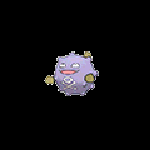

[[0.]]


In [32]:
from tensorflow.keras.preprocessing import image

img = image.load_img('images/images/koffing.png', target_size = (150, 150))
display(img)
img = np.expand_dims(img, axis=0)



model = load_model('pokemon_model.h5')

x = base_model.predict(img)
result = model.predict(x)

print(result)
                     

In [21]:
# Plot training and validation accuracy

def plot_training_validation_acc(history, smooth=False, smooth_factor=0.8):
    def smooth_curve(points, factor=0.8):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    if smooth:
        acc = smooth_curve(acc)
        val_acc = smooth_curve(val_acc)
        loss = smooth_curve(loss)
        val_loss = smooth_curve(val_loss)

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
    
plot_training_validation_acc(history)

KeyError: 'acc'

In [28]:
whos

Variable                         Type                  Data/Info
----------------------------------------------------------------
Activation                       type                  <class 'tensorflow.python<...>.layers.core.Activation'>
BS                               int                   20
BatchNormalization               type                  <class 'tensorflow.python<...>n_v2.BatchNormalization'>
Conv2D                           type                  <class 'tensorflow.python<...>rs.convolutional.Conv2D'>
Dense                            type                  <class 'tensorflow.python<...>keras.layers.core.Dense'>
Dropout                          type                  <class 'tensorflow.python<...>ras.layers.core.Dropout'>
EPOCHS                           int                   30
Flatten                          type                  <class 'tensorflow.python<...>ras.layers.core.Flatten'>
INIT_LR                          float                 0.001
ImageDataGenerator         